# Lab 5: Image Stitching for Panoramas

For this assignment, you will be writing a program that creates an image panorama from 3 images.  In general, this technique should be applicable to any number of photographs.  The approach described below will work well for collective fields of view up to 90&deg; or even 120&deg;, but won't produce ideal results for large fields of view approaching or surpassing 180&deg;.  For large fields of view, cylindrical or spherical projection is required.

When we construct a panorama, we assume that all of the photographs were taken from the exact same location and that the images are related by pure rotation (no translation of the camera).  The easiest way to create the panorama is to project all of the photos onto a plane.  One photo must be selected to be the base/center photo.  The other photos are aligned to this base photo by identifying a homography (a planar warp specified by 4 pairs of source/destination points) relating each pair.  Each of the other images is appropriately warped and composited onto the plane (the base image doesn’t need to be warped).

In this lab, you will be testing your setup for the following three images:
        

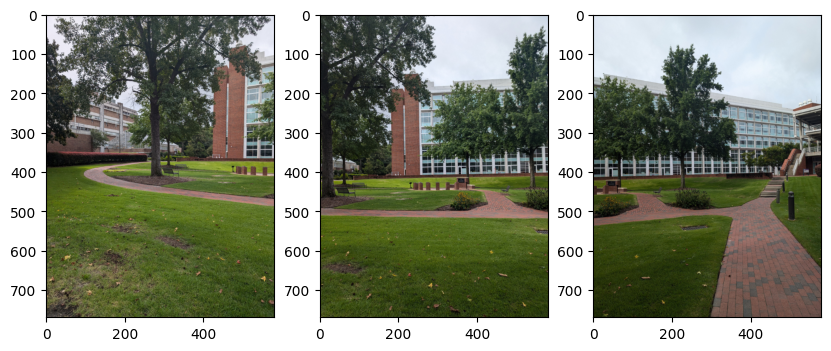

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

left = cv2.imread("im1_left.jpg")
center = cv2.imread("im1_center.jpg")
right = cv2.imread("im1_right.jpg")

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(left[:,:,::-1])
axes[1].imshow(center[:,:,::-1])
axes[2].imshow(right[:,:,::-1])
plt.show()

### Part A: Finding Interest Points/Descriptors
We will be using OpenCV for this project, which you should already have installed. Although the SIFT algorithm is patented and used to require a separate install, it is now included in the newer versions of OpenCV. A good tutorial on how to use SIFT features in OpenCV is found [here](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html).  The first step to registering or aligning two or more images is to identify locations in each image that are distinctive or stand out.  The `sift.detectAndCompute()` routine produces both these interest points and their corresponding SIFT descriptors.  The first step of producing a panorama is to load all of the relevant images and find the interest points and their descriptors.

For this part:
* Create a function called `getKeypoints` that takes in an image, converts it to grayscale, computes its keypoints and descriptions, and returns them.
* Output a visual showing the keypoints for all three images using OpenCV's `drawKeypoints` function. Make sure to use the `flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS` argument, which scales the circle based on the scale of each keypoint. An example is provided in the examples document on Canvas.

In [2]:
def getKeypoints(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()

    # NOTE: keypoints have an (x, y), scale, orientation, response (strength of feature), and octave (layer of the scale space where it was found)
    # NOTE: descriptors are 128 element vector describing the neighborhood of the corresponding keypoint
    
    keypoints, descriptors = sift.detectAndCompute(image = gray, mask = None)

    return keypoints, descriptors, gray



def draw_kp(images, titles):

    plt.figure(figsize = (10, 10))

    for i, (image, title) in enumerate(zip(images, titles)):
        kp, _, gray = getKeypoints(image)

        canvas = cv2.drawKeypoints(
            image = gray, 
            keypoints = kp, 
            outImage = None, 
            flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )

        plt.subplot(1, len(images), i + 1) # 1 row, num of images as columns, current position
        plt.imshow(canvas, cmap = 'gray')
        plt.title(f'{title}')
    
    plt.show()


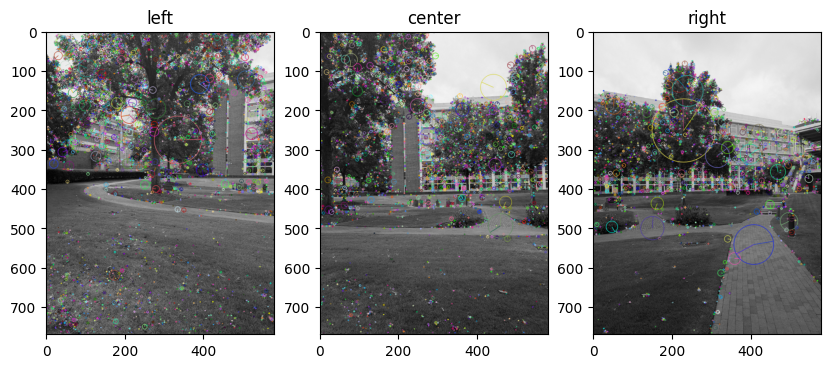

In [3]:
images = [left, center, right]
titles = ['left', 'center', 'right']

draw_kp(images, titles)

### Part B: Matching Features

Next, given the features present in each image, you need to match the features so as to determine corresponding points between adjacent/overlapping images.  [This page](https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html) provides details to do feature matching using `cv2.BFMatcher()`, analogous to the approach proposed by David Lowe in his original implementation.  Be aware that the resulting match is one directional. 

For this part:
* Create a function called `getMatches` that takes in two sets of SIFT descriptions and returns matches between them. Use `knnMatch` and use a ratio test to eliminate bad matchese as described in [this tutorial](https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html).
* Output a visual showing the matches between left-center and right-center using OpenCV's `drawMatches` or `drawMatchesKNN` function. An example is provided on the Canvas examples document.

In [4]:
def getMatches(query_des, train_des, ratio = .75):

    # init brute force matcher
    bf = cv2.BFMatcher(normType = cv2.NORM_L2, crossCheck = False)
    # find matches
    matches = bf.knnMatch(queryDescriptors = query_des, trainDescriptors = train_des, k = 2)
    return [ m for m, n in matches if m.distance < ratio * n.distance ]

def draw_matches(query_image, kpq, train_image, kpt, matches, title):

    result = cv2.drawMatches(
        img1 = query_image, 
        keypoints1 = kpq, 
        img2 = train_image, 
        keypoints2 = kpt, 
        matches1to2 = matches, 
        outImg = None,
        flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize = (5, 5))
    plt.imshow(result[...,:: -1])
    plt.title(title)
    plt.show()

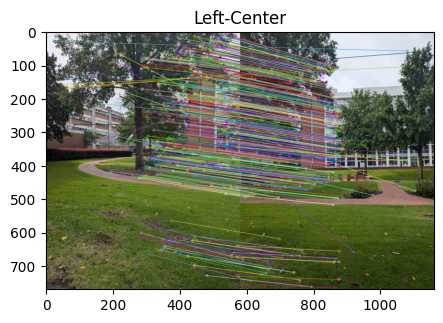

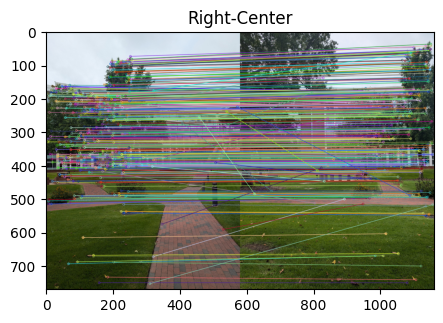

In [5]:
# keypoints and descriptors
kp_l, des_l, _ = getKeypoints(left)
kp_c, des_c, _ = getKeypoints(center)
kp_r, des_r, _ = getKeypoints(right)

# Matches
matches_lc = getMatches(des_l, des_c) # left and center matches
matches_rc = getMatches(des_r, des_c) # center and right

# show left-center
draw_matches(left, kp_l, center, kp_c, matches_lc, 'Left-Center')
# show center-right
draw_matches(right, kp_r, center, kp_c, matches_rc, 'Right-Center')

### Part C: Estimating Pairwise Homographies using RANSAC

Use the RANSAC algorithm ([Szeliski](http://szeliski.org/Book/), Ch 8.1.4), estimate the homography between each pair of images. For this section, you may use `cv2.findHomography()` and its associated RANSAC implementation. Alternatively, you can use the code from Lab 4 to generate the homography matrix and implement RANSAC yourself.

For this part:
* Create a function called `getHomography` that takes in two sets of keypoints and a list of matches and returns a best homography using the RANSAC algorithm. 
* Output a visual showing the warped images after the applied homography using `cv2.warpPerspective()`.

`Too Stubborn to use the given RANSAC functions...`
---

`Point Class`

In [6]:
class Point():
    def __init__(self,x,y):
        self.x = x
        self.y = y

`Build Homography`

In [ ]:
def get_homography(s0, s1, s2, s3, t0, t1, t2, t3):

    x0s = s0.x
    y0s = s0.y
    x0t = t0.x
    y0t = t0.y

    x1s = s1.x
    y1s = s1.y
    x1t = t1.x
    y1t = t1.y

    x2s = s2.x
    y2s = s2.y
    x2t = t2.x
    y2t = t2.y

    x3s = s3.x
    y3s = s3.y
    x3t = t3.x
    y3t = t3.y

    # linear constraints betwixt source and target
    A = np.matrix([
            [x0s, y0s, 1, 0, 0, 0, -x0t * x0s, -x0t * y0s],
            [0, 0, 0, x0s, y0s, 1, -y0t * x0s, -y0t * y0s],
            [x1s, y1s, 1, 0, 0, 0, -x1t * x1s, -x1t * y1s],
            [0, 0, 0, x1s, y1s, 1, -y1t * x1s, -y1t * y1s],
            [x2s, y2s, 1, 0, 0, 0, -x2t * x2s, -x2t * y2s],
            [0, 0, 0, x2s, y2s, 1, -y2t * x2s, -y2t * y2s],
            [x3s, y3s, 1, 0, 0, 0, -x3t * x3s, -x3t * y3s],
            [0, 0, 0, x3s, y3s, 1, -y3t * x3s, -y3t * y3s]
        ])

    # column vector of target coords
    b = np.array([
            [x0t],
            [y0t],
            [x1t],
            [y1t],
            [x2t],
            [y2t],
            [x3t],
            [y3t]
        ])
    
    try:
        # A^-1 @ b
        solutions = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        # the matrix isn't invertible
        A += np.eye(A.shape[0]) * 1e-10 # add SMALL value to matrix to make it invertible
        solutions = np.linalg.solve(A, b)

    # homogenize the matrix
    solutions = np.append(solutions, [[1.0]], axis = 0)

    # reshape homography to 3x3 matrix
    homography = np.reshape(solutions, (3,3))
    
    return homography

`Custom RANSAC`

In [8]:
def ransac_homography(kp_q, kp_t, matches, max = 1000, threshold = 5.0):
    import random

    best_H = None
    max_inliers = 0
    best_inliers = []

    for _ in range(max):
        samples = random.sample(matches, 4)

        query_points = [Point(*kp_q[m.queryIdx].pt) for m in samples]
        train_points = [Point(*kp_t[m.trainIdx].pt) for m in samples]

        H = get_homography(*query_points, *train_points)

        inliers = []

        for m in matches:

            pt1 = np.array([*kp_q[m.queryIdx].pt, 1.0]) # homogenized coords
            pt2 = np.array(kp_t[m.trainIdx].pt)

            projected_pt = H @ pt1
            projected_pt /= projected_pt[2] # normalize to grab (x, y)

            # euclidean distance as the reprojection error
            error = np.linalg.norm(pt2 - projected_pt[:2])

            # check if distance is w/in threshold
            if error < threshold:
                inliers.append(m)

            # update best homography
            if len(inliers) > max_inliers:
                max_inliers = len(inliers)
                best_H = H
                best_inliers = inliers
            
    return best_H, best_inliers

`Bilinear interpolation`

In [9]:
def interpolate(image: np.ndarray, x: float, y: float) -> float | int:
    
    h, w, _ = image.shape

    # get neighboring points
    # clip to w/in bounds if necessary
    x0 = max(int(np.floor(x)), 0)
    y0 = max(int(np.floor(y)), 0)
    x1 = min(x0 + 1, w - 1) 
    y1 = min(y0 + 1, h - 1)

    # distances/weights between TL pixel and orginal pixel
    xw = x - x0
    yw = y - y0

    # neighboring pixel values
    p00 = image[y0, x0].astype(np.float32) # TL
    p01 = image[y0, x1].astype(np.float32) # TR
    p10 = image[y1, x0].astype(np.float32) # BL
    p11 = image[y1, x1].astype(np.float32) # BR

    return ( 
        p00 * (1 - xw) * (1 - yw) + 
        p01 * xw * (1 - yw) + 
        p10 * (1 - xw) * yw + 
        p11 * xw * yw
    )

`Compose function aka perspective warp`

In [10]:
def compose(source: np.ndarray, target: np.ndarray, transform: np.ndarray) -> np.ndarray:
    
    # dimension grabbing
    h, w, _ = source.shape
    target_h, target_w, _ = target.shape

    result = np.copy(target)
    
    # invert transformation matrix for backward mapping
    transform_inv = np.linalg.inv(transform)

    for y in range(target_h):
        for x in range(target_w):
            
            # homogenize
            # aka add one dimension
            xy_target_homogenized = np.array([x, y, 1]) # (x, y) to (x, y, 1)

            # backward mapping
            xy_backward_map = transform_inv @ xy_target_homogenized.T # convert to column vector by using "T"
            xy_backward_map = np.array(xy_backward_map).flatten() # convert to 1d array

            # homogenous divide to get source coordinates
            x_source = xy_backward_map[0] / xy_backward_map[2]
            y_source  = xy_backward_map[1] / xy_backward_map[2]

            # just another classic boundary check
            if 0 <= x_source < w and 0 <= y_source < h: # we can siimply discard anything not in bounds

                result[y, x] = interpolate(source, x_source, y_source)

    return result

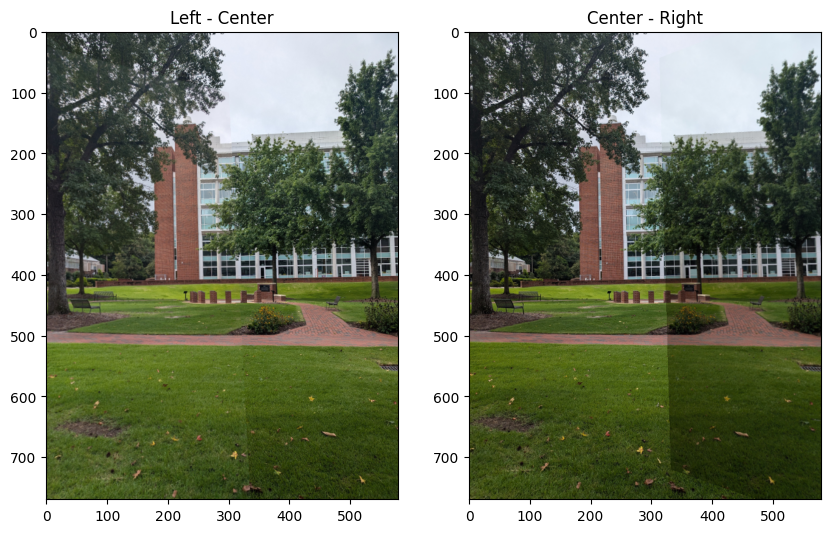

In [11]:
H_left, inliers = ransac_homography(kp_l, kp_c, matches_lc)
stitched_lc = compose(left, center, H_left)

H_right, inliers = ransac_homography(kp_r, kp_c, matches_rc)
stitched_rc = compose(right, center, H_right)

_, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 10))
axes[0].imshow(stitched_lc[...,:: -1]), axes[0].set_title('Left - Center')
axes[1].imshow(stitched_rc[...,:: -1]), axes[1].set_title('Center - Right')
plt.show()

### Part D: Creating the Mosaic

When you warped the images in Part C, you may have noticed that `cv2.warpPerspective()` cuts off the part of the image that doesn't fit in the frame. To fix this, we will need to create a larger canvas image and then map the three images into this space to create the final panorama.

To create the final panorama:
* Create a canvas image that is 3 times larger in height and width than the center image.
* Create a translation matrix that accounts for this padding, where tx = columns and ty = rows.
* Multiply the two homography matrices by this translation matrix.
* Use `cv2.warpPerspective()` to map the left and right images onto the canvas. **Make sure the destination size is the canvas shape.**
* Place the center image in the middle of the canvas, overwriting any values from the left or right images.
* Crop the compositied image to the smallest bounding box, removing any remaining black border (`np.nonzero` may be helpful)

An example of this very simple (but not ideal) compositing operation is given in the examples document on Canvas. **It is okay if your result has noticable seams between the three images.**

In [12]:
def crop(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    nonzero = np.nonzero(gray)

    y_min, y_max = nonzero[0].min(), nonzero[0].max()
    x_min, x_max = nonzero[1].min(), nonzero[1].max()

    return image[y_min : y_max, x_min : x_max]

In [13]:
def blendImages(left, center, right, H_left, H_right):

    h, w, _ = center.shape
    
    canvas = np.zeros((3 * h, 3 * w, 3), dtype = np.uint8)
    y = (canvas.shape[0] - h) // 2
    x = (canvas.shape[1] - w) // 2

    T = np.array([
        [1, 0, w],
        [0, 1, h],
        [0, 0, 1]
    ])

    left_transform = T @ H_left
    right_transform = T @ H_right

    canvas = compose(left, np.copy(canvas), left_transform)
    canvas[ y : y + h, x : x + w] = center
    canvas = compose(right, np.copy(canvas), right_transform)

    return crop(canvas)

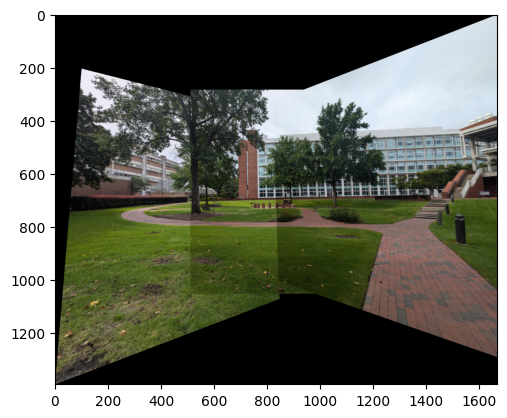

In [14]:
panorama = blendImages(left, center, right, H_left, H_right)

plt.imshow(panorama[..., ::-1])
plt.show()

### Part E: Putting It All Together

You now have all needed components to create a mosaic out of three images. For this last part, combine/call all of your previous functions together into a single stitching function that takes three images as input and output the panorama image.

You can test your function on the two provided test cases.


In [15]:
def imageStitch(left, center, right):

    ''' keypoints '''
    kp_left, des_left, _ = getKeypoints(left)
    kp_center, des_center, _ = getKeypoints(center)
    kp_right, des_right, _ = getKeypoints(right)

    ''' matches '''
    left_center_matches = getMatches(des_left, des_center)
    right_center_matches = getMatches(des_right, des_center)

    ''' RANSAC '''
    H_left, _ = ransac_homography(kp_left, kp_center, left_center_matches)
    H_right, _ = ransac_homography(kp_right, kp_center, right_center_matches)

    ''' stitch '''
    panorama = blendImages(left, center, right, H_left, H_right)

    return panorama

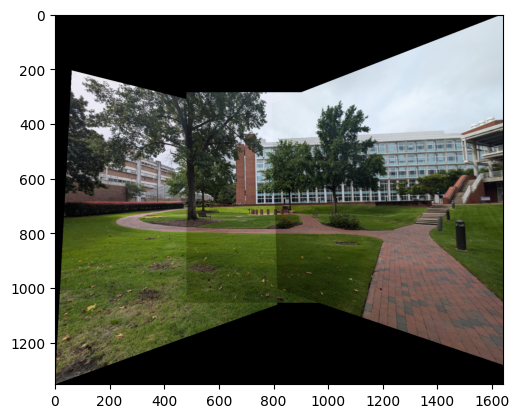

In [16]:
left = cv2.imread("im1_left.jpg")
center = cv2.imread("im1_center.jpg")
right = cv2.imread("im1_right.jpg")

result = imageStitch(left,center,right)
plt.imshow(result[:,:,::-1]);plt.show()

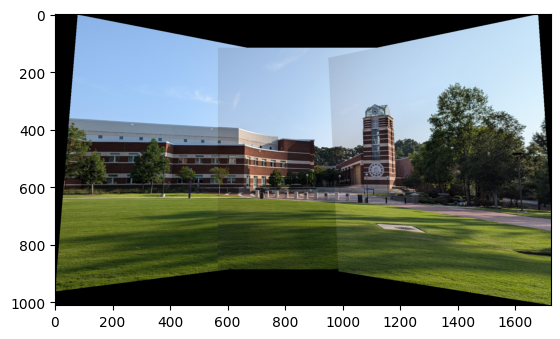

In [17]:
left = cv2.imread("im2_left.jpg")
center = cv2.imread("im2_center.jpg")
right = cv2.imread("im2_right.jpg")

result = imageStitch(left,center,right)
plt.imshow(result[:,:,::-1]);plt.show()

### Possible Extensions for Extra Credit (5 pts)
Once you have completed your fully functional image stitcher, there are many improvements you can make on this process. For 5 pts extra credit, you can implement one of the following:
* Allow for larger images to be stitched efficiently/effectively by shrinking the image down to a standard small size for computing keypoints, then mapping those keypoints locations back onto the larger size image before computing the homography.
* Automatically detecting which image is the center by computing matches between all pairs of images, then using number of good matches as an indicator of side-by-side images.
* Improving the blending operation by using alpha masking and a composition technique such as averaging, Voronoi, or gradient-domain blending.
* Allow for more than three and overlapping images to be stitched together.

You may need to provide your own images to test these extensions.